In [1]:
import os, shutil

In [9]:
test_dir =  "/Volumes/kenta/datasets/cancer/test"

In [10]:
base_dir = '../../data/sample/'

train_dir = os.path.join(base_dir, 'train/')

validation_dir = os.path.join(base_dir, 'validation/')

train_type_1 = os.path.join(train_dir, 'Type_1')

train_type_2 = os.path.join(train_dir, 'Type_2')

train_type_3 = os.path.join(train_dir, 'Type_3')

validation_type_1 = os.path.join(validation_dir, 'Type_1')

validation_type_2 = os.path.join(validation_dir, 'Type_2')

validation_type_3 = os.path.join(validation_dir, 'Type_3')

In [11]:
from keras import layers
from keras import models
from keras import optimizers
conv_base = models.Sequential()
conv_base.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64 , 3)))
conv_base.add(layers.MaxPooling2D((2,2)))
conv_base.add(layers.Conv2D(64, (3,3), activation='relu'))
conv_base.add(layers.MaxPooling2D((2,2)))
conv_base.add(layers.Conv2D(128, (3,3), activation='relu'))
conv_base.add(layers.MaxPooling2D((2,2)))
conv_base.add(layers.Conv2D(128, (3,3), activation='relu'))
conv_base.add(layers.MaxPooling2D((2,2)))

Using TensorFlow backend.


In [12]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         147584    
__________

In [125]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 2, 2, 128))
    labels = np.zeros(shape=(sample_count, 1))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical')
    i= 0
    for inputs_batch, labels_batch in generator:
        if i == 0:
            print('inputs_batch is: ', labels_batch.shape)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` onces every image has been seen once.
            break
    return features, labels


In [14]:
# code below is for reading images smoothly without generating warnings
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
import numpy as np

In [16]:
train_features, train_labels = extract_features(train_dir, 600) 
validation_features, validation_labels = extract_features(validation_dir, 150)

Found 600 images belonging to 3 classes.
inputs_batch is:  (20, 3)
Found 150 images belonging to 1 classes.
inputs_batch is:  (20, 1)


In [123]:
test_dir = '/Volumes/kenta/datasets/cancer/test_class'

In [126]:
test_features, test_labels = extract_features(test_dir, 512) 

Found 512 images belonging to 1 classes.
inputs_batch is:  (20, 1)


In [130]:
transformed_test_features = np.reshape(test_features, (512, -1))
print(transformed_test_features.shape)

(512, 512)


In [132]:
print(transformed_test_features[0].shape)

(512,)


In [127]:
print(test_features.shape)

(512, 2, 2, 128)


In [17]:
print(train_features.shape, train_labels.shape)
print(validation_features.shape, validation_labels.shape)

(600, 2, 2, 128) (600, 3)
(150, 2, 2, 128) (150, 3)


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.svm import SVC

In [19]:
train_features[0].ndim

3

In [20]:
transformed_train_features = np.reshape(train_features, (600, -1))
transformed_validation_features = np.reshape(validation_features, (150, -1))

In [21]:
transformed_train_features.shape

(600, 512)

In [49]:
transformed_validation_features.shape

(150, 512)

In [36]:
for i in range(8, 15):
    print(np.where(train_labels[i] == 1)[0][0])

2
0
0
1
2
1
0


In [34]:
for i in range(8, 15):
    print(train_labels[i])

[ 0.  0.  1.]
[ 1.  0.  0.]
[ 1.  0.  0.]
[ 0.  1.  0.]
[ 0.  0.  1.]
[ 0.  1.  0.]
[ 1.  0.  0.]


In [43]:
len(train_labels)

600

In [44]:
transformed_train_labels = np.array([np.where(train_labels[i]==1)[0][0] for i in range(len(train_labels))])

In [46]:
transformed_train_labels.shape

(600,)

In [47]:
transformed_validation_labels = np.array([np.where(validation_labels[i]==1)[0][0] for i in range(len(validation_labels))])

In [50]:
transformed_validation_labels.shape

(150,)

In [51]:
scaler.fit(transformed_train_features)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [52]:
X_train_scaled = scaler.transform(transformed_train_features)
X_val_scaled  = scaler.transform(transformed_validation_features)

In [53]:
X_train_scaled.shape

(600, 512)

In [55]:
X_val_scaled.shape

(150, 512)

In [56]:
type(train_labels)

numpy.ndarray

In [57]:
y_train_labels = transformed_train_labels 
y_val_labels = transformed_validation_labels


In [58]:
svm = SVC(C=100)
svm.fit(X_train_scaled, y_train_labels)
svm.score(X_val_scaled, y_val_labels)

0.28000000000000003

In [59]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [60]:
X_train = transformed_train_features
X_val = transformed_validation_features

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train,  y_train_labels)
print("best cross-validation accuracy:", grid.best_score_)
print("test set score: ", grid.score(X_val, y_val_labels))
print("best parameters: ", grid.best_params_)

best cross-validation accuracy: 0.465
test set score:  0.286666666667
best parameters:  {'svm__gamma': 0.01, 'svm__C': 10}


In [96]:
svm = SVC(C=10, gamma=0.01)

In [97]:
test_dir

'../../data/test'

In [10]:
# code below is for reading images smoothly without generating warnings
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
for data_batch, labels_batch in validation_generator:
    print('data batch:', data_batch.shape)
    print('labels batch:', labels_batch.shape)
    break

data batch: (20, 64, 64, 3)
labels batch: (20, 3)


In [13]:
history = model.fit_generator(
      train_generator,  
      steps_per_epoch=600//20, #  it will take 30 batches to see 600 samples since each batch size is 20
      epochs=30, 
      validation_data=validation_generator, 
      validation_steps=150//20) # it will take 7.5 batches to see 150 validation samples since each batch size is 20

Epoch 1/30
30/30 [==============================] - 553s - loss: 1.1007 - acc: 0.3233 - val_loss: 1.0961 - val_acc: 0.3462

In [14]:
model.save("naive_first_1.h5")

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Two graphs below shows no indication of overfitting

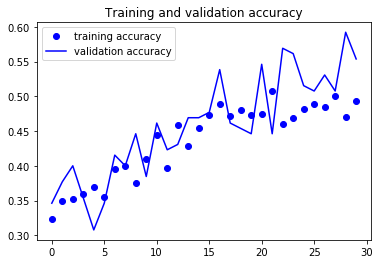

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title("Training and validation accuracy")
plt.legend()

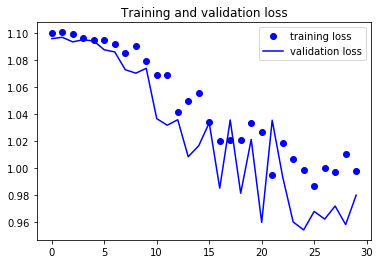

In [109]:
path = '/Volumes/kenta/datasets/cancer/'

In [110]:

import pandas as pd
from glob import glob
import cv2
import numpy as np

In [111]:
sample_subm = pd.read_csv(path + '/sample_submission.csv')
sample_subm.head(n=3)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.168805,0.527346,0.303849
1,1.jpg,0.168805,0.527346,0.303849
2,2.jpg,0.168805,0.527346,0.303849


In [112]:
ids = sample_subm['image_name'].values
len(ids)

512

In [113]:
ids[:3]

array(['0.jpg', '1.jpg', '2.jpg'], dtype=object)

In [34]:
test_path = '/Volumes/kenta/datasets/cancer/test/'

In [116]:
test_dir = '../../data/test/'

In [117]:
glob(test_dir + ids[0] )

['../../data/test/0.jpg']

# make a prediction for each sample on the test set  and
# save to the csv file called "sum.csv"

In [156]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(transformed_train_features)
X_train = scaler.transform(transformed_train_features)

from sklearn.svm import SVC
svm = SVC(C=10, gamma=0.01, probability=True)
svm.fit(X_train, trans_train_labels)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
 {'svm__gamma': 0.01, 'svm__C': 10}

In [143]:
len(os.listdir(test_dir))

512

In [65]:
from sklearn.svm import SVC
svm = SVC(C=10, gamma=0.01, probability=True)
svm.fit(X_train_scaled, y_train_labels)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [74]:
svm.predict_proba(X_val[0])

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.32614971,  0.2661733 ,  0.40767699]])

In [68]:
X_val.shape

(150, 512)

In [144]:
os.listdir(test_dir)[0]

'0.jpg'

In [181]:
image = cv2.imread(test_dir + '0.jpg')
image = image.astype('float32') // 255
image.shape

(4128, 3096, 3)

In [182]:
transformed_train_features.shape

(600, 512)

In [183]:
image.shape

(4128, 3096, 3)

In [184]:
image = image.flatten()

In [185]:
image_trans = cv2.resize(image, (512,1))

In [186]:
image_trans.shape

(1, 512)

In [157]:
image_trans = scaler.transform(image_trans)

In [158]:
svm.predict_proba(image_trans)

array([[ 0.14773954,  0.11840404,  0.73385642]])

In [134]:
svm.predict_proba(transformed_test_features[3])

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.32438333,  0.25912824,  0.41648843]])

In [127]:
image = cv2.imread(test_dir + '0.jpg')
image = cv2.resize(image, (64, 64))
image = image.astype('float32') // 255
image = np.reshape(image, (1 , 64 * 64*3))
image = scaler.transform(image)
image_list.append(image)

ValueError: operands could not be broadcast together with shapes (1,12288) (512,) (1,12288) 

In [124]:
image.shape

(4128, 3096, 3)

In [197]:
ls /Volumes/kenta/datasets/cancer/

histogram/             sample_submission.csv  train/
new/                   segment/
sample/                sub-sampled/


In [76]:
import pandas as pd

In [77]:
sample_submission = pd.read_csv("/Volumes/kenta/datasets/cancer/sample_submission.csv")

In [78]:
sample_submission.head(n=3)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.168805,0.527346,0.303849
1,1.jpg,0.168805,0.527346,0.303849
2,2.jpg,0.168805,0.527346,0.303849


In [79]:
sample_submission['image_name'].values[:4]

array(['0.jpg', '1.jpg', '2.jpg', '3.jpg'], dtype=object)

In [84]:
test_dir = '/Volumes/kenta/datasets/cancer/test/'

In [85]:
import cv2

In [93]:
X_val[0].shape

(512,)

In [120]:
X_train[0].shape

(512,)

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
for i in sample_submission['image_name'].values[:4]:
    image = cv2.imread(test_dir + i)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.reshape(1, image.shape[0]*image.shape[1])
    print(image.shape)

(1, 12780288)
(1, 7990272)
(1, 12780288)
(1, 7990272)


In [135]:
predictions  = []
for i in range(len(sample_submission['image_name'].values[:])):
    prediction = svm.predict_proba(transformed_test_features[i])
    predictions.append(prediction)

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it c

In [136]:
len(predictions)

512

In [137]:
predictions[:8]

[array([[ 0.31874307,  0.25894519,  0.42231174]]),
 array([[ 0.3212104 ,  0.25455845,  0.42423114]]),
 array([[ 0.33370389,  0.2572669 ,  0.40902921]]),
 array([[ 0.32438333,  0.25912824,  0.41648843]]),
 array([[ 0.34583025,  0.25793113,  0.39623863]]),
 array([[ 0.3336241 ,  0.25803986,  0.40833604]]),
 array([[ 0.31634655,  0.26510596,  0.41854749]]),
 array([[ 0.34941339,  0.25523311,  0.3953535 ]])]

In [138]:
import pandas as pd

In [158]:
type_1_predict = np.array([predictions[i][0][0] for i in range(len(predictions))])
type_2_predict = np.array([predictions[i][0][1] for i in range(len(predictions))])
type_3_predict = np.array([predictions[i][0][2] for i in range(len(predictions))])

In [159]:
type_1_predict[:3]

array([ 0.31874307,  0.3212104 ,  0.33370389])

In [160]:
predictions[1][0][2]

0.42423114368939607

In [171]:
svm_deep = pd.DataFrame({'image_name': sample_submission['image_name'].values})
svm_deep = pd.DataFrame({
                         'Type_1':type_1_predict, 
                          'Type_2':type_2_predict, 
                         'Type_3':type_3_predict, 
                         'image_name': sample_submission['image_name'].values})

In [172]:
svm_deep.head()

,Type_1,Type_2,Type_3,image_name
0,0.318743,0.258945,0.422312,0.jpg
1,0.321210,0.254558,0.424231,1.jpg
2,0.333704,0.257267,0.409029,2.jpg
3,0.324383,0.259128,0.416488,3.jpg
4,0.345830,0.257931,0.396239,4.jpg


In [179]:
columns = svm_deep.columns.tolist()

In [181]:
columns

['Type_1', 'Type_2', 'Type_3', 'image_name']

In [185]:
columns = [columns[-1], columns[0], columns[1], columns[2]]

In [193]:
svm_deep = svm_deep[columns] 

In [194]:
svm_deep.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.318743,0.258945,0.422312
1,1.jpg,0.321210,0.254558,0.424231
2,2.jpg,0.333704,0.257267,0.409029
3,3.jpg,0.324383,0.259128,0.416488
4,4.jpg,0.345830,0.257931,0.396239


In [195]:
svm_deep.to_csv("svm_deep.csv", index=False)

In [196]:
svm_deep2 = pd.read_csv("svm_deep.csv")
svm_deep2.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.318743,0.258945,0.422312
1,1.jpg,0.321210,0.254558,0.424231
2,2.jpg,0.333704,0.257267,0.409029
3,3.jpg,0.324383,0.259128,0.416488
4,4.jpg,0.345830,0.257931,0.396239


In [165]:
import pandas as pd
subm = pd.read_csv("sum.csv")

In [166]:
subm.head(n=-3)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.289515,0.327993,0.382492
1,1.jpg,0.278124,0.327512,0.394364
2,2.jpg,0.289515,0.327993,0.382492
3,3.jpg,0.289515,0.327993,0.382492
4,4.jpg,0.251329,0.310983,0.437689
5,5.jpg,0.289515,0.327993,0.382492
6,6.jpg,0.225790,0.305254,0.468956
7,7.jpg,0.289515,0.327993,0.382492
8,8.jpg,0.269224,0.322217,0.408559
9,9.jpg,0.260615,0.313574,0.425811
